In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('gdrive/My Drive/Spotify/spotify.csv')

In [ ]:
data.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [ ]:
data.shape

(32833, 23)

In [ ]:
data.isnull().sum()

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [ ]:
X = data.dropna(inplace=False)

In [ ]:
y = X.pop("track_popularity")

In [ ]:
y /= 100
y.describe()

count    32828.000000
mean         0.424836
std          0.249805
min          0.000000
25%          0.240000
50%          0.450000
75%          0.620000
max          1.000000
Name: track_popularity, dtype: float64

In [ ]:
numeric_features = list(X.select_dtypes(include="number").columns)
numeric_features

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

In [ ]:
catagorized_features = ['playlist_genre']

In [ ]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), catagorized_features),
)

In [ ]:
def group_split(X, y, group):
  splitter = GroupShuffleSplit(train_size=0.8)
  train, test = next(splitter.split(X, y, groups=group))
  return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, X["track_artist"])

In [ ]:
print("shape of:\nX_train: {}\nX_valid: {}\ny_train: {}\ny_valid: {}".format(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape))

shape of:
X_train: (26598, 22)
X_valid: (6230, 22)
y_train: (26598,)
y_valid: (6230,)


In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [ ]:
input_shape = [X_train.shape[1]]
input_shape

[18]

In [ ]:
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(units = 128, input_shape=input_shape, activation="relu"),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(units = 128, activation="relu"),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(units = 1)
])

In [ ]:
model.compile(
    optimizer="adam",
    loss="mae"
)

In [ ]:
early_stopping = EarlyStopping(
    min_delta = 0.001,
    patience = 50,
    restore_best_weights = True
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 512,
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
52/52 [==============================] - 1s 10ms/step - loss: 0.8080 - val_loss: 0.2096
Epoch 2/100
52/52 [==============================] - 0s 7ms/step - loss: 0.5287 - val_loss: 0.2069
Epoch 3/100
52/52 [==============================] - 0s 8ms/step - loss: 0.3732 - val_loss: 0.2027
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 0.2781 - val_loss: 0.2010
Epoch 5/100
52/52 [==============================] - 0s 7ms/step - loss: 0.2363 - val_loss: 0.2002
Epoch 6/100
52/52 [==============================] - 0s 8ms/step - loss: 0.2153 - val_loss: 0.1991
Epoch 7/100
52/52 [==============================] - 0s 8ms/step - loss: 0.2067 - val_loss: 0.1981
Epoch 8/100
52/52 [==============================] - 0s 8ms/step - loss: 0.2014 - val_loss: 0.1968
Epoch 9/100
52/52 [==============================] - 0s 7ms/step - loss: 0.1998 - val_loss: 0.1964
Epoch 10/100
52/52 [==============================] - 0s 7ms/step - loss: 0.1995 - val_loss: 0.1965
Epoch 11

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,val_loss
0,0.807994,0.209583
1,0.528727,0.206883
2,0.373215,0.202686
3,0.278065,0.201045
4,0.236290,0.200151


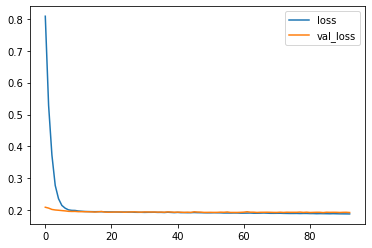

In [ ]:
history_df.loc[:, ["loss", "val_loss"]].plot()

In [ ]:
print("lowest validation loss:", history_df["val_loss"].min())

lowest validation loss: 0.1928337663412094
